In [1]:
# env init
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import joblib
import pickle
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

In [2]:
# make some changes to the dataframe (enforce, unbalanced)
# 3 train df, 1 is original, 2 is enforced, 3 is unbalanced

working_path = "./enforced/"
# enforce part

# read traindf
# ori and enforce index are the same, but have different image files
train_df = pd.read_csv("./train.csv")
val_df = pd.read_csv("./val.csv")
test_df = pd.read_csv("./test.csv")

categories = [
    d
    for d in os.listdir("./Aerial_Landscapes")
    if os.path.isdir(os.path.join("./Aerial_Landscapes", d))
]

train_df_enforce = train_df.copy()

# because enforce need to edit img, so save edited img to a new folder, not in the original folder
# enforced_img_dir=os.path.join(working_path, 'img')

image_enforced_paths = []
image_enforced_labels = []


def augment_image(image):
    # rotate
    angle = np.random.randint(0, 360)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))

    # flip
    flip = np.random.choice([0, 1])
    image = cv2.flip(image, flip)

    # noise
    noise = np.random.normal(0, 0.1, image.shape).astype(np.float32)
    image = image.astype(np.float32) + noise
    image = np.clip(image, 0, 255).astype(np.uint8)

    # brightness
    brightness = np.random.randint(-50, 50)
    image = image.astype(np.int16) + brightness
    image = np.clip(image, 0, 255).astype(np.uint8)

    return image


# augment the images in the dataframe
for i in range(len(train_df_enforce)):
    image_path = train_df_enforce.iloc[i]["image_path"]

    image_label = train_df_enforce.iloc[i]["label"]
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error reading image {image_path}")
        continue
    # augment the image
    augmented_image = augment_image(image)

    # save the augmented image to the dataframe
    augmented_image_path = os.path.join(working_path + "/img", f"{image_label}_{i}.jpg")
    # replace \ with / in the path
    augmented_image_path = augmented_image_path.replace("\\", "/")
    cv2.imwrite(
        augmented_image_path, augmented_image
    )  # save the augmented image to the new folder
    image_enforced_paths.append(augmented_image_path)
    image_enforced_labels.append(image_label)


# add the augmented images to the dataframe
train_df_enforce = pd.DataFrame(
    {"image_path": image_enforced_paths, "label": image_enforced_labels}
)
# show count of images
print(train_df_enforce["label"].value_counts())

# save the dataframe to a csv file
train_df_enforce.to_csv(working_path + "/train_enforce.csv", index=False)
# ETA 56s

label
Airport        560
Highway        560
City           560
Port           560
Railway        560
Lake           560
Mountain       560
Residential    560
River          560
Beach          560
Desert         560
Agriculture    560
Grassland      560
Parking        560
Forest         560
Name: count, dtype: int64


In [3]:
# SIFT for getting keypoints and descriptors
sift_enforced = cv2.SIFT_create()
# save sift descriptors and keypoints
sift_enforced_descriptors_list = []

# start sift, only on train df enforce
for index, row in train_df_enforce.iterrows():
    image_path = row["image_path"]
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift_enforced.detectAndCompute(gray_image, None)

    if descriptors is not None and descriptors.ndim == 2:
        sift_enforced_descriptors_list.append(descriptors)

# show number of keypoints and descriptors
print("###ENFORCED TRAIN DF###")
print(f"Number of descriptors: {len(sift_enforced_descriptors_list)}")


# save
with open(working_path + "/sift_enforced_descriptors_list.pkl", "wb") as f:
    pickle.dump(sift_enforced_descriptors_list, f)
# ETA 2m 38s

###ENFORCED TRAIN DF###
Number of descriptors: 8367


In [4]:
# build boW

# flatten the list of descriptors and fit kmeans
if sift_enforced_descriptors_list:
    all_descriptors = np.vstack(sift_enforced_descriptors_list)

# define KNN config
k = 300  # number of clusters
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
kmeans.fit(all_descriptors)

def get_bow_histogram(descriptors, kmeans):
    if descriptors is not None:
        # predict the cluster for each descriptor
        cluster_indices = kmeans.predict(descriptors)
        # count the occurrences of each cluster index
        histogram, _ = np.histogram(cluster_indices, bins=np.arange(k + 1), density=True)
        return histogram
    else:
        # if descriptors is None, return a zero histogram
        return np.zeros(k)
    
def get_bow_features(dataframe,image_path, kmeans):
    x_temp= []
    y_temp= []

    for index, row in dataframe.iterrows():
        image_path = row['image_path']
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift_enforced.detectAndCompute(gray_image, None)

        # get the histogram for the image
        histogram = get_bow_histogram(descriptors, kmeans)

        x_temp.append(histogram)
        y_temp.append(row['label'])
    return np.array(x_temp), np.array(y_temp)

x_train = []
y_train = []

for index, row in train_df_enforce.iterrows():
    image_path = row['image_path']
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift_enforced.detectAndCompute(gray_image, None)

    # get the histogram for the image
    histogram = get_bow_histogram(descriptors, kmeans)

    x_train.append(histogram)
    y_train.append(row['label'])

# convert to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val, y_val = get_bow_features(val_df, image_path, kmeans)
x_test, y_test = get_bow_features(test_df, image_path, kmeans)


# save to disk
np.save(working_path + 'x_train.npy', x_train)
np.save(working_path + 'y_train.npy', y_train)
np.save(working_path + 'x_val.npy', x_val)
np.save(working_path + 'y_val.npy', y_val)
np.save(working_path + 'x_test.npy', x_test)
np.save(working_path + 'y_test.npy', y_test)
# ETA 4m 38s

d:\Dev\anaconda3\envs\SIFT_KNN\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [5]:
# start training, by KNN


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

# test the model on test set
y_pred = knn.predict(x_test)

# try on validation set
y_val_pred = knn.predict(x_val)

# save knn model
joblib.dump(knn, working_path + 'knn_model.pkl')
# save y_pred and y_val_pred
np.save(working_path + 'y_pred.npy', y_pred)
np.save(working_path + 'y_val_pred.npy', y_val_pred)
# save y_test and y_val
np.save(working_path + 'y_test.npy', y_test)
np.save(working_path + 'y_val.npy', y_val)

Accuracy: 0.48
              precision    recall  f1-score   support

 Agriculture       0.63      0.34      0.44       120
     Airport       0.31      0.39      0.35       120
       Beach       0.43      0.19      0.26       120
        City       0.37      0.83      0.51       120
      Desert       0.62      0.23      0.34       120
      Forest       0.56      0.95      0.71       120
   Grassland       0.76      0.24      0.37       120
     Highway       0.37      0.41      0.39       120
        Lake       0.19      0.07      0.10       120
    Mountain       0.49      0.78      0.60       120
     Parking       0.76      0.82      0.79       120
        Port       0.84      0.36      0.50       120
     Railway       0.45      0.83      0.58       120
 Residential       0.49      0.70      0.58       120
       River       0.31      0.09      0.14       120

    accuracy                           0.48      1800
   macro avg       0.51      0.48      0.44      1800
weighted av

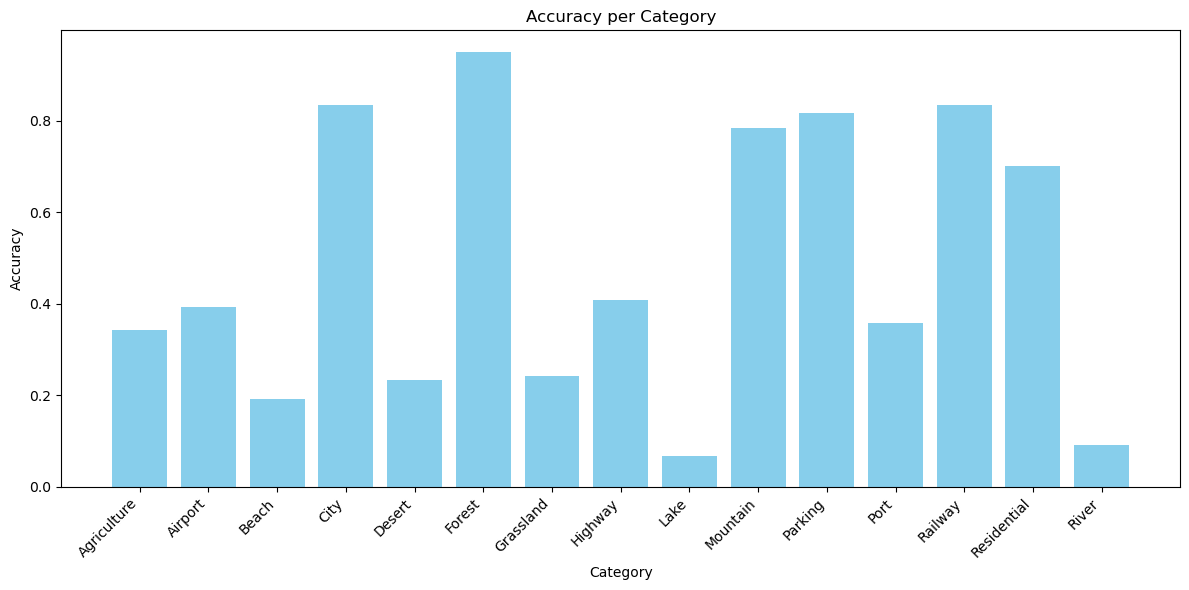

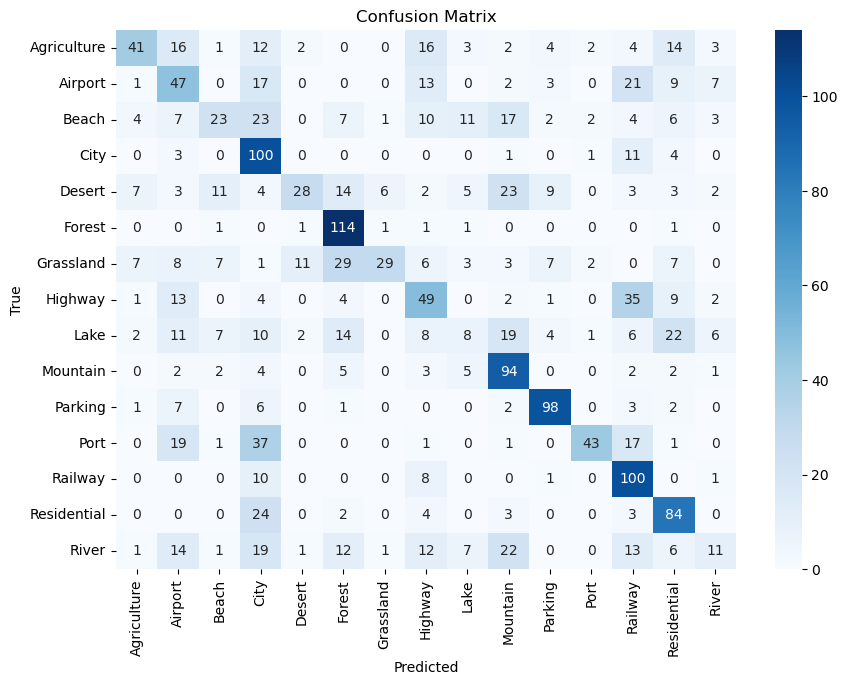

In [8]:
# show results by plt


# show accuracy
accuracy = accuracy_score(y_test, y_pred)  
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred, target_names=categories))

# show accuracy by each cateq,using bar chart via plt
# x axis 
# y axis accuracy

accuracy_per_class = {}
for i, category in enumerate(categories):
    accuracy_per_class[category] = {
        'accuracy': accuracy_score(y_test[y_test == category], y_pred[y_test == category]),
        'precision': classification_report(y_test, y_pred, target_names=categories, output_dict=True)[category]['precision'],
        'recall': classification_report(y_test, y_pred, target_names=categories, output_dict=True)[category]['recall']
    }
accuracy_df = pd.DataFrame(accuracy_per_class).T
accuracy_df = accuracy_df.sort_values(by='accuracy', ascending=False)
accuracy_df = accuracy_df.reset_index()
accuracy_df.columns = ['Category', 'Accuracy', 'Precision', 'Recall']
accuracy_df['Category'] = pd.Categorical(accuracy_df['Category'], categories=categories, ordered=True)
accuracy_df = accuracy_df.sort_values('Category')
plt.figure(figsize=(12, 6))
plt.bar(accuracy_df['Category'], accuracy_df['Accuracy'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.title('Accuracy per Category')
plt.tight_layout()
plt.show()


# show confusion matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred, labels=categories)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Validation Accuracy:  0.4955555555555556
              precision    recall  f1-score   support

 Agriculture       0.57      0.35      0.43       120
     Airport       0.37      0.46      0.41       120
       Beach       0.43      0.19      0.26       120
        City       0.35      0.72      0.47       120
      Desert       0.62      0.28      0.39       120
      Forest       0.61      0.93      0.73       120
   Grassland       0.70      0.28      0.40       120
     Highway       0.36      0.40      0.38       120
        Lake       0.39      0.13      0.20       120
    Mountain       0.56      0.88      0.68       120
     Parking       0.76      0.78      0.77       120
        Port       0.84      0.38      0.53       120
     Railway       0.42      0.80      0.55       120
 Residential       0.49      0.69      0.57       120
       River       0.41      0.16      0.23       120

    accuracy                           0.50      1800
   macro avg       0.52      0.50      

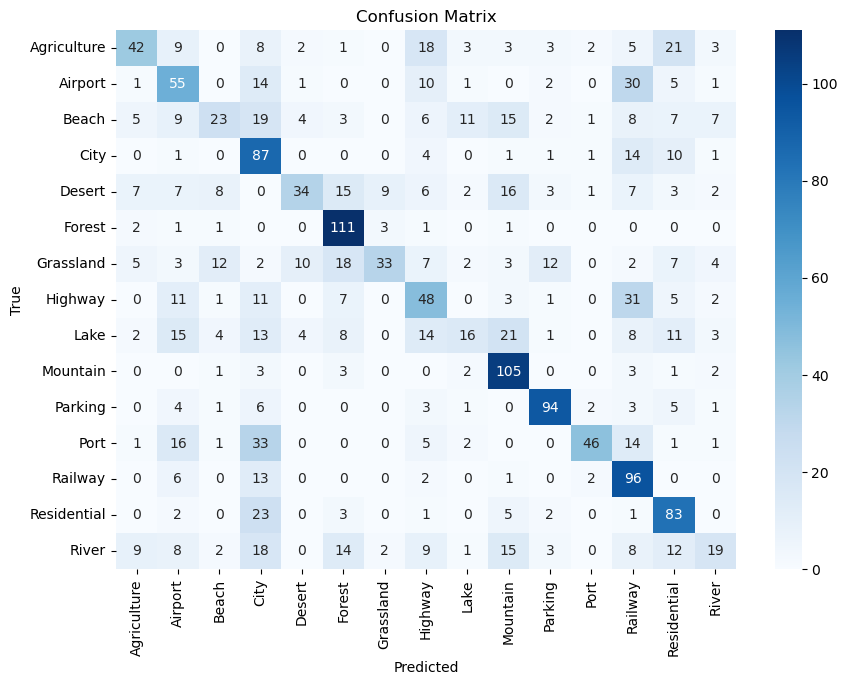

In [7]:
# val results
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=categories))
# show confusion matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_val, y_val_pred, labels=categories)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
